# Gold standard analysis

This notebook involves analysing the gold standard data against the knowledge graph

# Imports

In [15]:
import os
from tqdm import tqdm
import json
import pandas as pd
from itertools import product
from venn import venn
import matplotlib.pyplot as plt
from collections import defaultdict

from utils import get_disease_map, KG_DATA_PATH, DATA_DIR, create_venn_diagram, get_chem_map

# Load mapping file

In [2]:
mapping_dict = get_disease_map()
chemica_dict = get_chem_map()

# Load subgraph

In [3]:
openbiolinks_df = pd.read_csv(
    os.path.join(KG_DATA_PATH, 'normalized', 'openbiolink_kg_normalized.tsv'),
    sep='\t'
)

custom_df = pd.read_csv(
    os.path.join(KG_DATA_PATH, 'normalized', 'custom_kg_normalized.tsv'),
    sep='\t'
)

# Clinical trial info

In [4]:
clinical_df = pd.read_csv(
    'https://raw.githubusercontent.com/drug2ways/results/master/validation/data/PubChem-MeSH-slim-counts.tsv',
    sep='\t'
)

clinical_df['cid_id'] = clinical_df['cid_id'].apply(lambda x: f'pubchem.compound:{x}')
clinical_df['condition'] = clinical_df['condition'].apply(lambda x: f'mesh:{x}')

mondo_id = []
for i in tqdm(clinical_df['condition'], desc='Normalizing diseases'):
    mondo_id.append(mapping_dict.get(i))
    
clinical_df['mondo_id'] = mondo_id
clinical_df

Normalizing diseases: 100%|██████████| 57458/57458 [00:00<00:00, 1500244.77it/s]


,cid_id,condition,n_trials,mondo_id
0,pubchem.compound:10026,mesh:D004931,1,mondo:0008698
1,pubchem.compound:10071196,mesh:D000374,2,mesh:D000374
2,pubchem.compound:10071196,mesh:D000544,3,mondo:0004975
3,pubchem.compound:10071196,mesh:D001523,9,mondo:0005084
4,pubchem.compound:10071196,mesh:D003704,1,mondo:0001627
...,...,...,...,...
57453,pubchem.compound:999,mesh:D016543,1,mondo:0002714
57454,pubchem.compound:999,mesh:D017093,2,mesh:D017093
57455,pubchem.compound:999,mesh:D017114,2,mondo:0019542
57456,pubchem.compound:999,mesh:D022124,1,mesh:D022124


In [5]:
chem = set(clinical_df['cid_id'].tolist())
dis = set(clinical_df['mondo_id'].tolist())

# Collect chemical and disease data from KG

In [6]:
# Get chemicals

chemical_1 = set(openbiolinks_df.loc[openbiolinks_df['source'].str.contains('pubchem.compound')]['source'].tolist())
chemical_2 = set(custom_df.loc[custom_df['source'].str.contains('pubchem.compound')]['source'].tolist())

chemicals = chemical_1.union(chemical_2)

disease_1 = set(openbiolinks_df.loc[openbiolinks_df['target'].str.contains('mondo')]['target'].tolist())
disease_2 = set(custom_df.loc[custom_df['target'].str.contains('mondo')]['target'].tolist())

diseases = disease_1.union(disease_2)


# Comparison of clinical trial data with KG

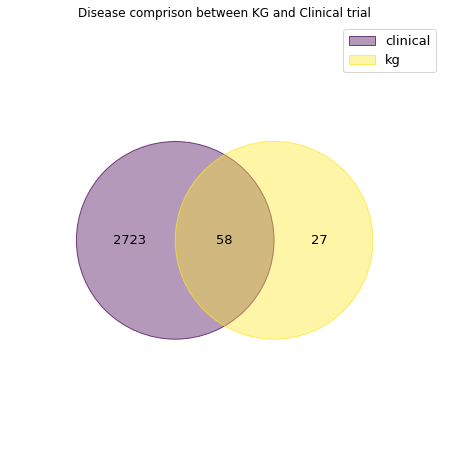

In [7]:
g = {'clinical': dis, 'kg': diseases}
plt = create_venn_diagram(data_dict=g, plot_title='Disease comprison between KG and Clinical trial')
plt.show()

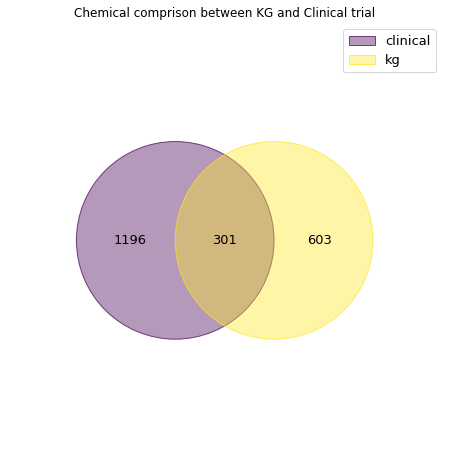

In [8]:
c = {'clinical': chem, 'kg': chemicals}
plt = create_venn_diagram(data_dict=c, plot_title='Chemical comprison between KG and Clinical trial')
plt.show()

# Saving intersection data

In [21]:
clinical_trial_pairs = defaultdict(int)

for row in tqdm(clinical_df.values, desc='Storing clinical pairs'):
    (
        pubchem_id,
        _,
        trial_num,
        mondo_id,
    ) = row
    
    if pubchem_id in chemicals and mondo_id in diseases:
        name = pubchem_id + '_' + mondo_id
        clinical_trial_pairs[name] = trial_num

len(clinical_trial_pairs)

Storing clinical pairs: 100%|██████████| 57458/57458 [00:00<00:00, 627901.99it/s]


1389

In [22]:
# Save pair dictionary for future use
with open(
    os.path.join(DATA_DIR, 'gold-standard', 'filtered-clinical_pairs.json'),
    'w'
) as f:
    json.dump(clinical_trial_pairs, f, ensure_ascii=False, indent=2)

# Drug indications

In [9]:
drug_df = pd.read_csv(
    os.path.join(DATA_DIR, 'gold-standard', 'drug_indication_df.tsv'),
    sep='\t',
    usecols=['drug', 'indication']
)

drug_df['indication'] = drug_df['indication'].apply(lambda x: f'umls:{x}')

mondo_id = []
for i in tqdm(drug_df['indication'], desc='Normalizing diseases'):
    mondo_id.append(mapping_dict.get(i))
    
drug_df['indication'] = mondo_id

pubchem_ids = []
for i in tqdm(drug_df['drug'], desc='Normalizing chemicals'):
    idx = chemica_dict.get(i)
    if idx is None:
        pubchem_ids.append(idx)
    else:
        pubchem_ids.append(f'pubchem.compound:{idx}')
    
drug_df['drug'] = pubchem_ids

drug_df.dropna(axis=0, how='any', inplace=True)
    
drug_df

Normalizing chemicals: 100%|██████████| 5926/5926 [00:00<00:00, 1397001.21it/s]


,drug,indication
53,pubchem.compound:5311128,mondo:0005133
54,pubchem.compound:5311128,mondo:0007254
213,pubchem.compound:5284373,mondo:0008383
214,pubchem.compound:5284373,mondo:0006733
215,pubchem.compound:5284373,mondo:0006733
...,...,...
5917,pubchem.compound:42611257,mondo:0005105
5918,pubchem.compound:5663,mondo:0005009
5922,pubchem.compound:5736,mondo:0005090
5923,pubchem.compound:5311507,mondo:0005090


In [10]:
chem = set(drug_df['drug'].tolist())
dis = set(drug_df['indication'].tolist())

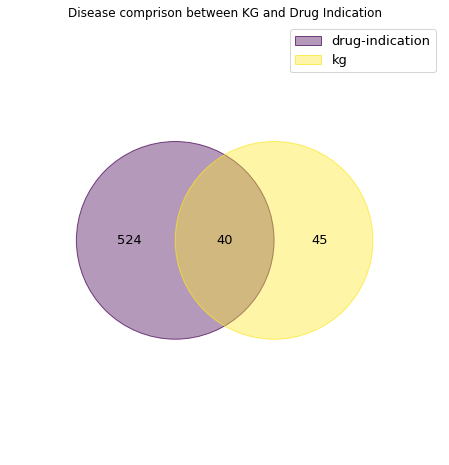

In [11]:
g = {'drug-indication': dis, 'kg': diseases}
plt = create_venn_diagram(data_dict=g, plot_title='Disease comprison between KG and Drug Indication')
plt.show()

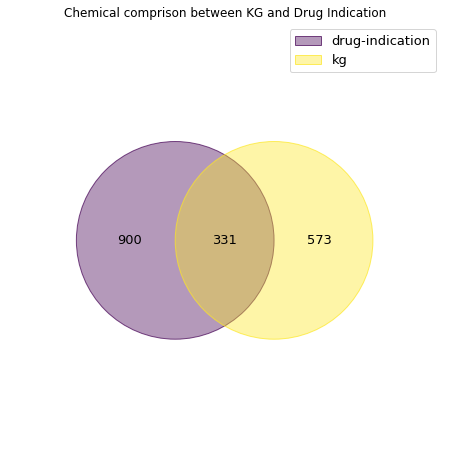

In [12]:
c = {'drug-indication': chem, 'kg': chemicals}
plt = create_venn_diagram(data_dict=c, plot_title='Chemical comprison between KG and Drug Indication')
plt.show()

In [23]:
trial_pairs = defaultdict(int)

for row in tqdm(drug_df.values, desc='Storing clinical pairs'):
    (
        pubchem_id,
        mondo_id,
    ) = row
    
    if pubchem_id in chemicals and mondo_id in diseases:
        name = pubchem_id + '_' + mondo_id
        trial_pairs[name] = 1

len(trial_pairs)

Storing clinical pairs: 100%|██████████| 4088/4088 [00:00<00:00, 811583.03it/s]


173

In [24]:
# Save pair dictionary for future use
with open(
    os.path.join(DATA_DIR, 'gold-standard', 'filtered-indications.json'),
    'w'
) as f:
    json.dump(trial_pairs, f, ensure_ascii=False, indent=2)